In [27]:
import tensorflow as tf
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation, Dropout
from keras import regularizers
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

%matplotlib inline
np.random.seed(20181111)

In [28]:
num_training=40
models = []
histories = []

def load_data():
    data = np.loadtxt('Trim_Debris_1.csv', delimiter=',', skiprows=1)
    
    #mean = np.mean(data, axis=0, keepdims=True)
    #delta = data - mean
    #std = np.sqrt(np.mean(delta**2, axis=0, keepdims=True))
    #data = delta / std
    
    #data_max = np.max(data, axis=0, keepdims=True)
    #data = data / data_max 
    
    np.random.shuffle(data) 
    
    X = data[:, 1:]
    y = data[:, 0]

    return X, y

X, y = load_data();
X, y = load_data();

print('Dataset: ', X.shape)

X_train = X[:num_training, :]
y_train = y[:num_training]

X_test = X[num_training:, :]
y_test = y[num_training:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Dataset:  (60, 38)
X_train shape: (40, 38)
y_train shape: (40,)
X_test shape: (20, 38)
y_test shape: (20,)


In [29]:
activation='relu'

def regularizer():
    return keras.regularizers.l2(0.0005)

dropout = 0.15
node_count = 38
#model
def build_mode():
    model = keras.models.Sequential([
        Dense(node_count, activation=activation, kernel_initializer='normal', kernel_regularizer=regularizer()),
        Dropout(dropout),
        Dense(int(node_count / 2), activation=activation, kernel_initializer='normal', kernel_regularizer=regularizer()),
        Dropout(dropout),
        Dense(int(node_count / 4), activation='sigmoid', kernel_initializer='normal', kernel_regularizer=regularizer()),
        Dropout(dropout),
        Dense(1)])


    def loss(y_true, y_pred):
        SS_res =  K.sum(K.square(y_true - y_pred)) 
        y_mean = K.mean(y_true)
        SS_reg = K.sum(K.square(y_pred - y_mean))
        SS_tot = SS_res + SS_reg
        print(K.int_shape(y_pred))
        return K.abs(SS_res/(SS_tot))
# getting r2
    def r2(y_true, y_pred):
        return 1.0 - loss(y_true, y_pred)

    
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
                  loss=loss,
                  metrics=[r2, 'mse', 'mae', 'mape', 'cosine'])
    models.append(model)
    return model

wrapped_model = KerasRegressor(build_fn=build_mode)
#fit the model
history = wrapped_model.fit(X_train, y_train,batch_size=40, epochs=3000, verbose=0, validation_split=0.05)
#conducting permutation 
perm = PermutationImportance(wrapped_model).fit(X_test, y_test)

model = models[-1]
histories.append(history)


(None, 1)
(None, 1)
20/20 [==============================] - 0s 74us/step


20/20 [==============================] - 0s 77us/step


In [30]:
eli5.show_weights(perm, top=None)


Weight,Feature
0.0240 ± 0.0481,x0
0.0164 ± 0.0315,x12
0.0093 ± 0.0436,x6
0.0056 ± 0.0080,x32
0.0027 ± 0.0017,x26
0.0017 ± 0.0029,x15
0.0014 ± 0.0061,x4
0.0014 ± 0.0042,x35
0.0014 ± 0.0024,x7
0.0008 ± 0.0009,x24


In [145]:
score_test = model.evaluate(X_test, y_test)
print("Test====")
print(model.metrics_names)
print(score_test)

20/20 [==============================] - 0s 116us/step
Test====
['loss', 'r2', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
[0.6569014191627502, 0.35224735736846924, 0.59978187084198, 0.47443467378616333, 246.802734375, -1.0]


In [54]:
score_train = model.evaluate(X_train, y_train)
print("Train====")
print(model.metrics_names)
print(score_train)

40/40 [==============================] - 0s 892us/step
Train====
['loss', 'r2', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
[0.24669846296310424, 0.7624582052230835, 0.012846711371093989, 0.06624356061220169, 101.18587799072266, -0.9999999880790711]


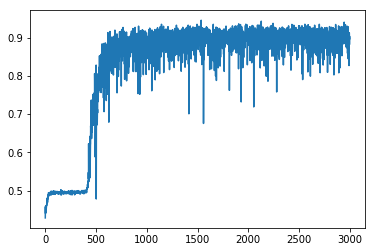

In [55]:
plot_begin = 0
history.history['r2'][plot_begin:]
plt.plot(history.history['r2'][plot_begin:])
#plt.plot(history.history['r2'][plot_begin:], label="Train")

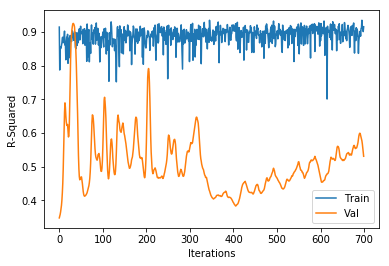

In [56]:
plot_begin = 800
# plot metrics

plt.plot(history.history['r2'][plot_begin:1500], label="Train")
plt.plot(history.history['val_r2'][plot_begin:1500], label="Val")
plt.ylabel('R-Squared')
plt.xlabel('Iterations')
plt.legend()
plt.show()

20/20 [==============================] - 0s 143us/step
Test====
['loss', 'r2', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
[0.5986971259117126, 0.4059191942214966, 0.011402188800275326, 0.06210324168205261, 133.72061157226562, -0.8999999761581421]
40/40 [==============================] - 0s 206us/step
Train====
['loss', 'r2', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
[0.19685706496238708, 0.8077592492103577, 0.001120322966016829, 0.023695531114935876, 53.114437866210935, -0.95]


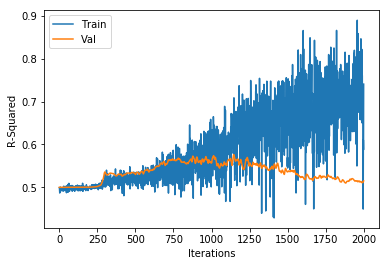

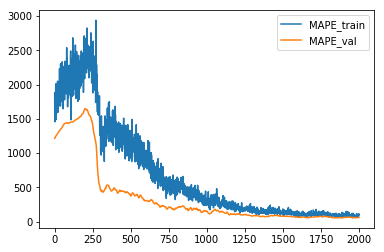

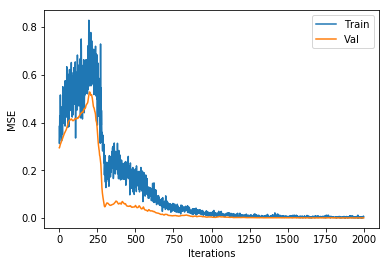

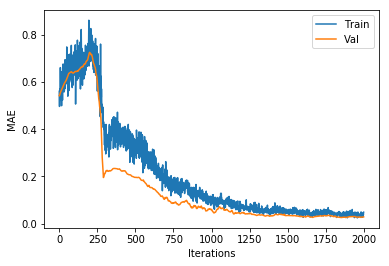

In [122]:
score_test = model.evaluate(X_test, y_test)
print("Test====")
print(model.metrics_names)
print(score_test)


score_train = model.evaluate(X_train, y_train)
print("Train====")
print(model.metrics_names)
print(score_train)

plot_begin = 0
# plot metrics

plt.plot(history.history['r2'][plot_begin:], label="Train")
plt.plot(history.history['val_r2'][plot_begin:], label="Val")
plt.ylabel('R-Squared')
plt.xlabel('Iterations')
plt.legend()
plt.show()

plt.plot(history.history['mean_absolute_percentage_error'][plot_begin:], label="MAPE_train")
plt.plot(history.history['val_mean_absolute_percentage_error'][plot_begin:], label="MAPE_val")
plt.legend()
plt.show()

plt.plot(history.history['mean_squared_error'][plot_begin:], label="Train")
plt.plot(history.history['val_mean_squared_error'][plot_begin:], label="Val")
plt.ylabel('MSE')
plt.xlabel('Iterations')
plt.legend()
plt.show()

plt.plot(history.history['mean_absolute_error'][plot_begin:], label="Train")
plt.plot(history.history['val_mean_absolute_error'][plot_begin:], label="Val")
plt.ylabel('MAE')
plt.xlabel('Iterations')
plt.legend()
plt.show()

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 38)                1482      
_________________________________________________________________
dropout_22 (Dropout)         (None, 38)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 19)                741       
_________________________________________________________________
dropout_23 (Dropout)         (None, 19)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 9)                 180       
_________________________________________________________________
dropout_24 (Dropout)         (None, 9)                 0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 10        
Total para

In [48]:
data = np.loadtxt('Total.csv', delimiter=',', skiprows=1)
results = np.zeros_like(data)
features = data[:, 1:]

for i in range(features.shape[1]):
    input_data = np.array(features, copy=True)
    input_data[:, i] *= 1.05
    a = model.predict(input_data)
    input_data = np.array(features, copy=True)
    input_data[:, i] *= 0.95
    b = model.predict(input_data)
    
    results[:, i] = np.reshape((a - b) / b, (-1))

results[:, 0] = data[:, 0]

header = None
with open('Total.csv', 'r') as f:
    header = f.readline().replace('\n', '')

np.savetxt('sensitivity_analysis.csv', results, fmt='%.8f', delimiter=',', header=header, comments='')

In [49]:
history.history['val_r2'][1999]

0.29265081882476807

In [17]:
y_pred = model.predict(X_test, batch_size=180)

In [18]:
y_pred

array([[0.10462728],
       [0.08493946],
       [0.0798827 ],
       [0.12999061],
       [0.07655764],
       [0.07648718],
       [0.07698484],
       [0.08880278],
       [0.08290084],
       [1.6896378 ],
       [0.09502402],
       [0.07913225],
       [0.51724315],
       [0.08734919],
       [0.07811134],
       [0.08856635],
       [1.8292977 ],
       [0.9773847 ],
       [0.08499914],
       [0.07985469]], dtype=float32)

In [19]:
y_test

array([2.27555556, 1.73222222, 0.37      , 0.20222222, 0.21      ,
       0.18166667, 0.645     , 0.179     , 0.01911111, 0.19333333,
       0.14366071, 0.25125   , 1.08285714, 0.062     , 0.148     ,
       0.044     , 2.16777778, 0.04      , 0.78      , 0.014     ])

In [20]:
np.savetxt("4.csv", y_pred, delimiter=",")

In [777]:
np.savetxt("5.csv", y_test, delimiter=",")

In [778]:
data1 = np.loadtxt('4.csv',delimiter=',',skiprows=0) 

In [780]:
data2 = np.loadtxt('5.csv',delimiter=',',skiprows=0) 

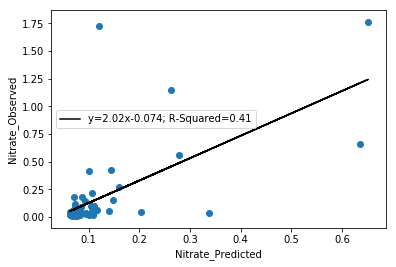

In [832]:
fit=np.polyfit(data1,data2,1)
fit_fn = np.poly1d(fit) 
plt.plot(data1, fit_fn(data1), '-k',label='y=2.02x-0.074; R-Squared=0.41')
plt.ylabel('Nitrate_Observed')
plt.xlabel('Nitrate_Predicted')
plt.legend()
plt.scatter(data1, data2)
plt.show()


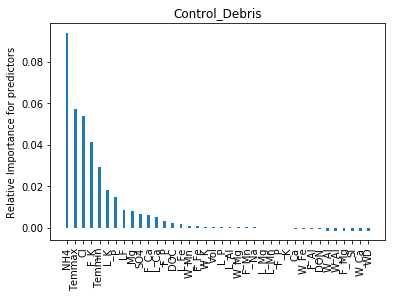

In [31]:
# this is for Control_Debris
#x = np.linspace(0, 2 * np.pi, 400)
#y = np.sin(x ** 2)
plt.close('all')
data1 = np.loadtxt('4.csv',delimiter=',',skiprows=0) 
n_bins = 10
#x = np.loadtxt('1.csv',delimiter=',',skiprows=0) 
x1 = np.loadtxt('3.csv',delimiter=',',skiprows=0) 
#y = np.fromstring('2.csv', dtype=int, sep=' ')
##y = np.loadtxt('2.csv',delimiter=',',skiprows=0)
#fig, axes = plt.subplots(nrows=1, ncols=1)
#ax0, ax1, ax2, ax3 = axes.flatten()
N = 38
ind = np.arange(N)
width = 0.35
p1 = plt.bar(ind, x1, width)
y = ('NH4', 'Temmax', 'Cl', 'F_K','Temmin','L_K','P','LF','Mg','SO4','F_Ca','L_Ca','F_P','DOC','L_Fe',
    'W_Mn','F_Fe','W_K','Vol','L_P','L_Al','W_Mg','F_Mn','Na','L_Mg','L_Mn','F_P','K','Ca','W_Fe','F_Al','DON','W_Al',
    'W_Al','F_Mg','Si','W_Ca','WD')

plt.ylabel('Relative Importance for predictors')
plt.title('Control_Debris')
#plt.xticks(ind, y,rotation='vertical')
plt.xticks(ind, y, rotation='vertical')
#plt.yticks(np.arange(0, 81, 10))
#plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()

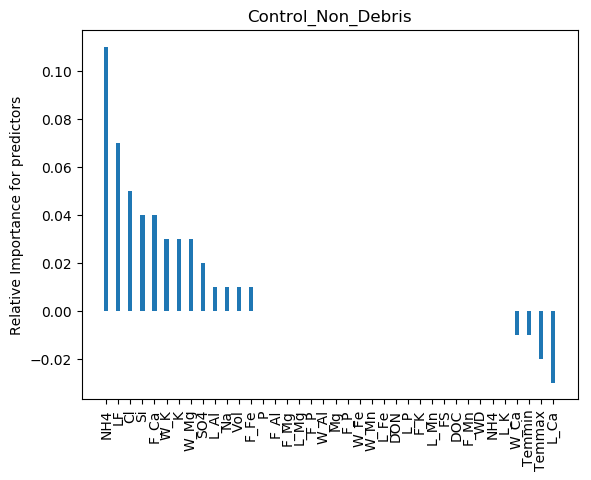

In [133]:
# this is for Control_Non_Debris_VIP
# x = np.linspace(0, 2 * np.pi, 400)
# y = np.sin(x ** 2)
plt.close('all')
data1 = np.loadtxt('4.csv',delimiter=',',skiprows=0) 
#x = np.loadtxt('1.csv',delimiter=',',skiprows=0) 
x1 = np.loadtxt('Control_Non_Debris_VIP.csv',delimiter=',',skiprows=0) 
#y = np.fromstring('2.csv', dtype=int, sep=' ')
##y = np.loadtxt('2.csv',delimiter=',',skiprows=0)
fig, axes = plt.subplots(nrows=1, ncols=1)
#ax0, ax1, ax2, ax3 = axes.flatten()
N = 38
ind = np.arange(N)
width = 0.35
p1 = plt.bar(ind, x1, width)
y = ('NH4', 'LF', 'Cl', 'Si','F_Ca','W_K','K','W_Mg','SO4','L_Al','Na','Vol','F_Fe','P','F_Al','F_Mg',
    'L_Mg','F_P','W_Al','Mg','F_P','W_Fe','W_Mn','L_Fe','DON','L_P','F_K','L_Mn','FS','DOC','F_Mn','WD','NH4','L_K',
    'W_Ca','Temmin','Temmax','L_Ca')

plt.ylabel('Relative Importance for predictors')
plt.title('Control_Non_Debris')
#plt.xticks(ind, y,rotation='vertical')
plt.xticks(ind, y, rotation='vertical')
#plt.yticks(np.arange(0, 81, 10))
#plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()

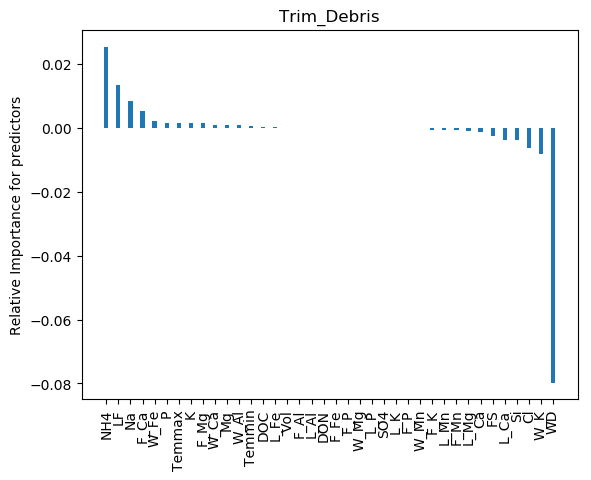

In [132]:
# this is for Trim_Debris_VIP
# x = np.linspace(0, 2 * np.pi, 400)
# y = np.sin(x ** 2)
plt.close('all')
# data1 = np.loadtxt('4.csv',delimiter=',',skiprows=0) 
#x = np.loadtxt('1.csv',delimiter=',',skiprows=0) 
x1 = np.loadtxt('Trim_Debris_VIP.csv',delimiter=',',skiprows=0) 
#y = np.fromstring('2.csv', dtype=int, sep=' ')
##y = np.loadtxt('2.csv',delimiter=',',skiprows=0)
fig, axes = plt.subplots(nrows=1, ncols=1)
#ax0, ax1, ax2, ax3 = axes.flatten()
N = 38
ind = np.arange(N)
width = 0.35
p1 = plt.bar(ind, x1, width)
y = ('NH4', 'LF', 'Na', 'F_Ca','W_Fe','P','Temmax','K','F_Mg','W_Ca','Mg','W_Al','Temmin','DOC','L_Fe',
    'Vol','F_Al','L_Al','DON','F_Fe','F_P','W_Mg','L_P','SO4','L_K','F_P','W_Mn','F_K','L_Mn','F_Mn','L_Mg','Ca','FS',
    'L_Ca','Si','Cl','W_K','WD')

plt.ylabel('Relative Importance for predictors')
plt.title('Trim_Debris')
#plt.xticks(ind, y,rotation='vertical')
plt.xticks(ind, y, rotation='vertical')
#plt.yticks(np.arange(0, 81, 10))
#plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()

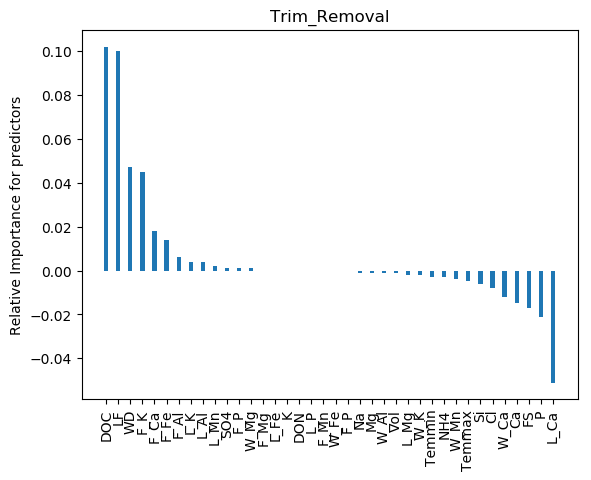

In [135]:
# this is for Trim_Removal_VIP
# x = np.linspace(0, 2 * np.pi, 400)
# y = np.sin(x ** 2)
plt.close('all')
# data1 = np.loadtxt('4.csv',delimiter=',',skiprows=0) 
#x = np.loadtxt('1.csv',delimiter=',',skiprows=0) 
x1 = np.loadtxt('Trim_Removal_VIP.csv',delimiter=',',skiprows=0) 
#y = np.fromstring('2.csv', dtype=int, sep=' ')
##y = np.loadtxt('2.csv',delimiter=',',skiprows=0)
fig, axes = plt.subplots(nrows=1, ncols=1)
#ax0, ax1, ax2, ax3 = axes.flatten()
N = 38
ind = np.arange(N)
width = 0.35
p1 = plt.bar(ind, x1, width)
y = ('DOC', 'LF', 'WD', 'F_K','F_Ca','F_Fe','F_Al','L_K','L_Al','L_Mn','SO4','F_P','W_Mg','F_Mg','L_Fe','K',
    'DON','L_P','F_Mn','W_Fe','F_P','Na','Mg','W_Al','Vol','L_Mg','W_K','Temmin','NH4','W_Mn','Temmax','Si','Cl','W_Ca',
    'Ca','FS','P','L_Ca')

plt.ylabel('Relative Importance for predictors')
plt.title('Trim_Removal')
#plt.xticks(ind, y,rotation='vertical')
plt.xticks(ind, y, rotation='vertical')
#plt.yticks(np.arange(0, 81, 10))
#plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()

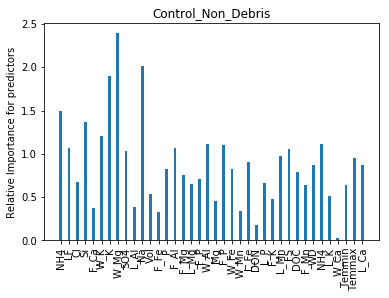

In [153]:
# this is for Control_Non_Debris_VIP based on PLSR
# x = np.linspace(0, 2 * np.pi, 400)
# y = np.sin(x ** 2)
plt.close('all')
data1 = np.loadtxt('4.csv',delimiter=',',skiprows=0) 
#x = np.loadtxt('1.csv',delimiter=',',skiprows=0) 
x1 = np.loadtxt('Control_Non_Debris_PLSR.csv',delimiter=',',skiprows=0) 
#y = np.fromstring('2.csv', dtype=int, sep=' ')
##y = np.loadtxt('2.csv',delimiter=',',skiprows=0)
# fig, axes = plt.subplots(nrows=1, ncols=1)
#ax0, ax1, ax2, ax3 = axes.flatten()
N = 38
ind = np.arange(N)
width = 0.35
p1 = plt.bar(ind, x1, width)
y = ('NH4', 'LF', 'Cl', 'Si','F_Ca','W_K','K','W_Mg','SO4','L_Al','Na','Vol','F_Fe','P','F_Al','F_Mg',
    'L_Mg','F_P','W_Al','Mg','F_P','W_Fe','W_Mn','L_Fe','DON','L_P','F_K','L_Mn','FS','DOC','F_Mn','WD','NH4','L_K',
    'W_Ca','Temmin','Temmax','L_Ca')

plt.ylabel('Importance for predictors')
plt.title('Control_Non_Debris')
#plt.xticks(ind, y,rotation='vertical')
plt.xticks(ind, y, rotation='vertical')
#plt.yticks(np.arange(0, 81, 10))
#plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()

In [2]:
var =10
var = 11
var = 'abc'

In [3]:
print(var + str(5))

abc5


In [4]:
print(-6%5)

4
